# SAREK VCF PROCESSING OF SARCOMA SAMPLE TO CALCULATE VAF

In [1]:
# Needed basic packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib_venn import venn2

# 1/ Reading the VCF files and formating as dataframe

In [2]:
import pandas as pd

# Import MUTECT2 vcf files with no header for sarcoma sample
mutect_df = pd.read_csv('/workspace/projects/sjd_melos/vcf_noheader/AX4967_vs_AB9766.mutect2.filtered.noheader.vcf.gz', sep="\t", header=0)
# Import STRELKA vcf files with no header for sarcoma sample with split information of SNV or indels

strelka_snv_df = pd.read_csv('/workspace/projects/sjd_melos/vcf_noheader/AX4967_vs_AB9766.strelka.somatic_snvs_noheader.vcf.gz', sep="\t", header=0)
strelka_ind_df = pd.read_csv('/workspace/projects/sjd_melos/vcf_noheader/AX4967_vs_AB9766.strelka.somatic_indels_noheader.vcf.gz', sep="\t", header=0)

In [3]:
mutect_df.shape + strelka_snv_df.shape +  strelka_ind_df.shape

(296411, 11, 1117938, 11, 124703, 11)

In [4]:
# Rename #CRHOM column to avoid future errors
mutect_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)
strelka_snv_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)
strelka_ind_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)

In [5]:
mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,patient1_AB9766,patient1_AX4967
0,chr1,14699,.,C,G,.,normal_artifact;strand_bias,"AS_FilterStatus=strand_bias;AS_SB_TABLE=128,15...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:218,2:0.013:220:100,0:102,2:216,2:106,112,0,2","0/1:67,4:0.071:71:33,0:30,4:64,4:22,45,0,4"
1,chr1,16125,.,T,G,.,normal_artifact;strand_bias,"AS_FilterStatus=strand_bias;AS_SB_TABLE=190,14...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:209,11:0.053:220:88,4:106,7:208,11:115,94,...","0/1:129,7:0.058:136:63,3:46,4:126,7:75,54,7,0"
2,chr1,16534,.,C,T,.,normal_artifact;panel_of_normals;strand_bias,"AS_FilterStatus=strand_bias;AS_SB_TABLE=89,160...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:186,8:0.042:194:90,5:83,2:180,8:77,109,1,7","0/1:63,4:0.074:67:28,2:33,2:61,4:12,51,0,4"
3,chr1,16571,.,G,A,.,map_qual;normal_artifact;strand_bias,"AS_FilterStatus=map_qual,strand_bias;AS_SB_TAB...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:163,18:0.105:181:78,9:67,5:159,18:67,96,2,16","0/1:33,4:0.127:37:12,1:21,2:33,4:9,24,0,4"
4,chr1,17375,.,A,G,.,clustered_events;normal_artifact;panel_of_normals,"AS_FilterStatus=SITE;AS_SB_TABLE=326,144|27,9;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:302,13:0.045:315:141,4:145,9:297,13:203,99...","0/1:168,23:0.127:191:80,12:79,11:164,23:123,45..."


# 2/ WORKING WITH MUTECT2 FILES

### A. Select mutations that passed filters

In [6]:
mutect_df = mutect_df[mutect_df['FILTER'] == 'PASS']
mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,patient1_AB9766,patient1_AX4967
36,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...","0|1:69,46:0.403:115:9,16:11,19:67,46:0|1:10418..."
48,chr1,187925,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=41,18|3,2;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:47,1:0.038:48:33,1:14,0:47,1:31,16,0,1","0/1:12,4:0.278:16:6,2:6,2:12,4:10,2,3,1"
68,chr1,414363,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:9,0:6,0:15,0:0|1:414363_T_C:...","0|1:10,11:0.522:21:6,6:4,5:10,11:0|1:414363_T_..."
69,chr1,414366,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:8,0:5,0:15,0:0|1:414363_T_C:...","0|1:10,11:0.522:21:6,6:4,5:10,11:0|1:414363_T_..."
73,chr1,414928,.,A,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=0,42|0,22;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:21,1:0.083:22:13,1:8,0:21,1:0,21,0,1","0/1:21,21:0.498:42:11,14:10,6:21,21:0,21,0,21"


### B. Find the number of reads and depth and create new columns with this information

In [7]:
# Check the header information of the VCF file to find this information and GATK manual information: https://gatk.broadinstitute.org/hc/en-us/articles/360035531692-VCF-Variant-Call-Format

# 1/ Rename columns
mutect_df = mutect_df.rename(columns={'patient1_AB9766': 'NORMAL', 'patient1_AX4967' : 'TUMOR'})

# 2/ Split tumor info from columns using ":" separator and add in new columns
mutect_df = pd.concat([mutect_df, mutect_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 3/ Rename new columns according to FORMAT column in original data 
mutect_df = mutect_df.rename(columns={0:'t_GT', 1: 't_AD', 2:'t_AF', 3: 't_DP', 4: 't_F1R2', 5:'t_F2R1', 6:'t_FAD', 7:'t_PGT', 8:'t_PID', 9:'t_PS', 10:'t_SB'})

In [8]:
# Now repeat 2/ and 3/ steps for the normal sample 
mutect_df = pd.concat([mutect_df, mutect_df['NORMAL'].str.split(':', expand=True)], axis=1)
mutect_df = mutect_df.rename(columns={0:'n_GT', 1: 'n_AD', 2:'n_AF', 3: 'n_DP', 4: 'n_F1R2', 5:'n_F2R1', 6:'n_FAD', 7:'n_PGT', 8:'n_PID', 9:'n_PS', 10:'n_SB'})

# Delete unnecessary information
mutect_df = mutect_df.drop(['n_GT','t_GT','n_F1R2','t_F1R2','n_FAD','t_FAD','n_PGT', 't_PGT', 'n_PID', 't_PID','n_PS','t_PS', 'n_SB', 't_SB', 'n_F2R1', 't_F2R1'], axis=1)

# Add sample name
mutect_df = mutect_df.assign(SAMPLE='sarcoma')
mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_AD,t_AF,t_DP,n_AD,n_AF,n_DP,SAMPLE
36,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...","0|1:69,46:0.403:115:9,16:11,19:67,46:0|1:10418...","69,46",0.403,115,"124,0",7.128e-03,124,sarcoma
48,chr1,187925,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=41,18|3,2;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:47,1:0.038:48:33,1:14,0:47,1:31,16,0,1","0/1:12,4:0.278:16:6,2:6,2:12,4:10,2,3,1","12,4",0.278,16,"47,1",0.038,48,sarcoma
68,chr1,414363,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:9,0:6,0:15,0:0|1:414363_T_C:...","0|1:10,11:0.522:21:6,6:4,5:10,11:0|1:414363_T_...","10,11",0.522,21,"15,0",0.059,15,sarcoma
69,chr1,414366,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:8,0:5,0:15,0:0|1:414363_T_C:...","0|1:10,11:0.522:21:6,6:4,5:10,11:0|1:414363_T_...","10,11",0.522,21,"15,0",0.059,15,sarcoma
73,chr1,414928,.,A,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=0,42|0,22;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:21,1:0.083:22:13,1:8,0:21,1:0,21,0,1","0/1:21,21:0.498:42:11,14:10,6:21,21:0,21,0,21","21,21",0.498,42,"21,1",0.083,22,sarcoma


In [9]:
# saving this table as a tsv compressed file in directory project

# mutect_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Mutect2_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

### C. Variant allele frequency calculation per each mutation

In [10]:
# Create a new table to calculate VAF
vaf_mutect_df = mutect_df

# Split allele depth frequency column information so it contains reference or alternative allele depth information
vaf_mutect_df[['t_ref_reads', 't_alt_reads']] = vaf_mutect_df['t_AD'].str.split(',', expand=True)
vaf_mutect_df[['n_ref_reads', 'n_alt_reads']] = vaf_mutect_df['n_AD'].str.split(',', expand=True)
vaf_mutect_df = vaf_mutect_df.drop(['t_AD','n_AD'], axis=1) # delete original columns

In [11]:
# Transform columns so they are not strings but operable
vaf_mutect_df[['t_DP', 't_ref_reads', 't_alt_reads']] = vaf_mutect_df[['t_DP', 't_ref_reads', 't_alt_reads']].astype(int)

# Calculate VAF and add it as new column (VAF = number of mutation reads in tumor sample / total depth of the position)

vaf_mutect_df['VAF'] = vaf_mutect_df['t_alt_reads'] / vaf_mutect_df['t_DP']  # obtain the VAF frequency of each allele
vaf_mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_AF,t_DP,n_AF,n_DP,SAMPLE,t_ref_reads,t_alt_reads,n_ref_reads,n_alt_reads,VAF
36,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,0.403,115,7.128e-03,124,sarcoma,69,46,124,0,0.40000
48,chr1,187925,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=41,18|3,2;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:47,1:0.038:48:33,1:14,0:47,1:31,16,0,1",...,0.278,16,0.038,48,sarcoma,12,4,47,1,0.25000
68,chr1,414363,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:9,0:6,0:15,0:0|1:414363_T_C:...",...,0.522,21,0.059,15,sarcoma,10,11,15,0,0.52381
69,chr1,414366,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:8,0:5,0:15,0:0|1:414363_T_C:...",...,0.522,21,0.059,15,sarcoma,10,11,15,0,0.52381
73,chr1,414928,.,A,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=0,42|0,22;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:21,1:0.083:22:13,1:8,0:21,1:0,21,0,1",...,0.498,42,0.083,22,sarcoma,21,21,21,1,0.50000


In [12]:
# Apply function to discriminate mutation type
def muttype_mutect2(row):
    # Infer mutation type
    if len(row['ALT']) != len(row['REF']):
        return 'INDEL'
    elif len(row['ALT']) == len(row['REF']) and len(row['REF']) > 1:
        return 'MNV'
    else:
        return 'SNV'

vaf_mutect_df['mut_type'] = vaf_mutect_df.apply(muttype_mutect2, axis=1)

In [13]:
vaf_mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_DP,n_AF,n_DP,SAMPLE,t_ref_reads,t_alt_reads,n_ref_reads,n_alt_reads,VAF,mut_type
36,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,115,7.128e-03,124,sarcoma,69,46,124,0,0.40000,SNV
48,chr1,187925,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=41,18|3,2;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:47,1:0.038:48:33,1:14,0:47,1:31,16,0,1",...,16,0.038,48,sarcoma,12,4,47,1,0.25000,SNV
68,chr1,414363,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:9,0:6,0:15,0:0|1:414363_T_C:...",...,21,0.059,15,sarcoma,10,11,15,0,0.52381,SNV
69,chr1,414366,.,A,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=25,0|11,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:15,0:0.059:15:8,0:5,0:15,0:0|1:414363_T_C:...",...,21,0.059,15,sarcoma,10,11,15,0,0.52381,SNV
73,chr1,414928,.,A,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=0,42|0,22;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:21,1:0.083:22:13,1:8,0:21,1:0,21,0,1",...,42,0.083,22,sarcoma,21,21,21,1,0.50000,SNV


In [14]:
# Reorder columns of the dataframe prior to export as CSV
# First check column information:
for col in vaf_mutect_df.columns:
    print(col)

# # Then reorganize columns
vaf_mutect_df.insert(12, 'n_AF', vaf_mutect_df.pop('n_AF'))
vaf_mutect_df.insert(15, 't_alt_reads', vaf_mutect_df.pop('t_alt_reads'))
vaf_mutect_df.insert(21, 'SAMPLE', vaf_mutect_df.pop('SAMPLE'))
vaf_mutect_df.insert(16, 'n_ref_reads', vaf_mutect_df.pop('n_ref_reads'))
vaf_mutect_df.insert(13, 't_DP', vaf_mutect_df.pop('t_DP'))
vaf_mutect_df.insert(14, 'n_DP', vaf_mutect_df.pop('n_DP'))
vaf_mutect_df.insert(17, 't_alt_reads', vaf_mutect_df.pop('t_alt_reads'))
# vaf_mutect_df.head()

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
t_DP
n_AF
n_DP
SAMPLE
t_ref_reads
t_alt_reads
n_ref_reads
n_alt_reads
VAF
mut_type


In [15]:
vaf_mutect_df.insert(16, 'n_ref_reads', vaf_mutect_df.pop('n_ref_reads'))
for col in vaf_mutect_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
n_AF
t_DP
n_DP
t_ref_reads
n_ref_reads
t_alt_reads
n_alt_reads
VAF
mut_type
SAMPLE


In [16]:
# saving this table as tsv file in directory project

# vaf_mutect_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Mutect2_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [17]:
# Extract data mut_type from mutect_df to discriminate between SNV and INDELS (note that Strelka does not discriminate between SNV and MNV)
vaf_mutect_snv_df = vaf_mutect_df.query("mut_type == 'SNV' | mut_type == 'MNV'")
vaf_mutect_indels_df = vaf_mutect_df.query("mut_type == 'INDEL'")
vaf_mutect_indels_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_AF,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,mut_type,SAMPLE
289,chr1,1315777,.,GGAGGGAGGGAGGCGGGCAGCGAGGGAGGCAGGGGCAGGGAGTGAG...,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=117,12|3,0;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:60,0:0.016:60:28,0:1,0:58,0:57,3,0,0",...,0.016,72,60,69,60,3,0,0.041667,INDEL,sarcoma
478,chr1,2682679,.,GCATCCGACAGCCTGGAGCAGCACCCACACACCCAGGTGAGCAACT...,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=110,2|8,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:111,3:0.033:114:31,2:15,1:114,4:0|1:268267...",...,0.033,6,114,1,111,5,3,0.833333,INDEL,sarcoma
707,chr1,2848792,.,CCTGTGCCCTGGGTGGGAGTGAGGAGTTGAGCCCCGTGCCTTGGGT...,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=87,172|1,2;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:142,0:6.979e-03:142:38,0:38,0:134,2:0|1:28...",...,6.979e-03,120,142,117,142,3,0,0.025000,INDEL,sarcoma
793,chr1,4069973,.,T,TA,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=67,63|31,33;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:97,1:0.010:98:44,1:41,0:95,1:51,46,1,0",...,0.010,96,98,33,97,63,1,0.656250,INDEL,sarcoma
801,chr1,4231919,.,CA,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=129,124|3,3;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:128,0:7.337e-03:128:57,0:57,0:126,0:61,67,0,0",...,7.337e-03,131,128,125,128,6,0,0.045802,INDEL,sarcoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293725,chrY,13880669,.,AG,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=44,52|20,11;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:70,0:0.014:70:30,0:29,0:68,0:31,39,0,0",...,0.014,57,70,26,70,31,0,0.543860,INDEL,sarcoma
293788,chrY,16426090,.,TA,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=30,33|10,12;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:47,0:0.020:47:21,0:19,0:46,0:23,24,0,0",...,0.020,38,47,16,47,22,0,0.578947,INDEL,sarcoma
293803,chrY,16962796,.,AC,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=50,40|17,13;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:66,0:0.015:66:25,0:34,0:64,0:38,28,0,0",...,0.015,54,66,24,66,30,0,0.555556,INDEL,sarcoma
293862,chrY,20073828,.,ACCGTAAATGTCT,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=19,11|4,0;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:14,1:0.061:15:5,0:4,0:14,0:0|1:20073828_AC...",...,0.061,19,15,16,14,3,1,0.157895,INDEL,sarcoma


In [18]:
# Export the list of Mutect2 SNV mutations into a tsv compressed table
# vaf_mutect_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Mutect2_snvmnv_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")
# vaf_mutect_indels_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Mutect2_indels_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

### D. Variant Allele Frequency Plot

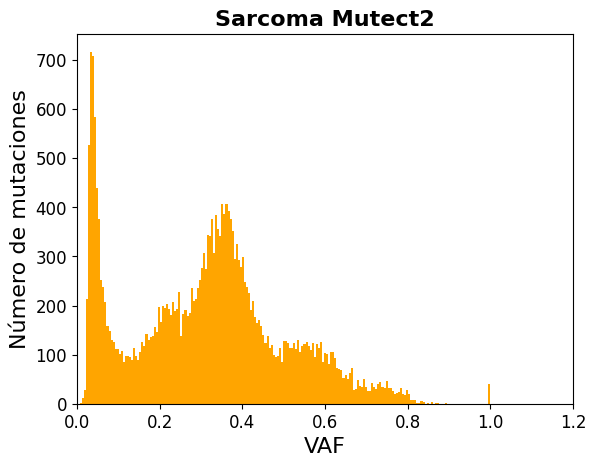

In [19]:
# Represent VAF from mutect2 table

plt.hist(vaf_mutect_df['VAF'].tolist(), bins = 200, color = 'orange')
plt.xlim([0,1.2])
plt.ylabel('Número de mutaciones', fontsize=16)
plt.xlabel('VAF', fontsize=16,)
plt.title('Sarcoma Mutect2', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_mutect2_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')

plt.show(vaf_mutect_df['VAF'].tolist())  

# 3/ WORKING WITH STRELKA FILES

In [20]:
# FOR THE SARCOMA TUMOR SNVs and INDELS (strelka_snv_df and strelka_ind_df)
# First select mutations that passed filters
strelka_snv_df = strelka_snv_df[strelka_snv_df['FILTER'] == 'PASS']
strelka_ind_df = strelka_ind_df[strelka_ind_df['FILTER'] == 'PASS']

strelka_snv_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)
strelka_ind_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00","40:40:30,31:8,34:2,5:38.59:0.42:0.00:0.00"
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00","45:45:33,33:8,35:5,6:45.70:0.21:0.00:0.00"
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","113:113:36,36:70,70:5,5:120.68:2.28:0.00:0.02"
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00","132:132:121,124:5,5:3,3:136.51:0.25:0.00:0.00"
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","118:118:49,49:61,63:9,10:119.46:0.15:0.00:0.00"


### A. FOR THE INDELS SAMPLE

In [21]:
# Check the header information of the VCF file to find this information and strelka manual in github or paper (https://github.com/Illumina/strelka/blob/v2.9.x/docs/userGuide/README.md; https://academic.oup.com/bioinformatics/article/28/14/1811/218573)

# 1/ Split tumor info from columns using ":" separator and add in new columns
strelka_ind_df = pd.concat([strelka_ind_df, strelka_ind_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 2/ Rename new columns according to FORMAT column in original data 
strelka_ind_df = strelka_ind_df.rename(columns={0:'t_DP', 1: 't_DP2', 2:'t_TAR', 3: 't_TIR', 4: 't_TOR', 5:'t_DP50', 6:'t_FDP50', 7:'t_SUBDP50', 8: 't_BCN50'})
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_DP2,t_TAR,t_TIR,t_TOR,t_DP50,t_FDP50,t_SUBDP50,t_BCN50
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00","40:40:30,31:8,34:2,5:38.59:0.42:0.00:0.00",40,40,"30,31","8,34","2,5",38.59,0.42,0.00,0.00
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00","45:45:33,33:8,35:5,6:45.70:0.21:0.00:0.00",45,45,"33,33","8,35","5,6",45.70,0.21,0.00,0.00
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","113:113:36,36:70,70:5,5:120.68:2.28:0.00:0.02",113,113,"36,36","70,70","5,5",120.68,2.28,0.00,0.02
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00","132:132:121,124:5,5:3,3:136.51:0.25:0.00:0.00",132,132,"121,124","5,5","3,3",136.51,0.25,0.00,0.00
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","118:118:49,49:61,63:9,10:119.46:0.15:0.00:0.00",118,118,"49,49","61,63","9,10",119.46,0.15,0.00,0.00


In [22]:
# Now repeat 1/ and 2/ steps for the normal sample 
strelka_ind_df = pd.concat([strelka_ind_df, strelka_ind_df['NORMAL'].str.split(':', expand=True)], axis=1)
strelka_ind_df = strelka_ind_df.rename(columns={0:'n_DP', 1: 'n_DP2', 2:'n_TAR', 3: 'n_TIR', 4: 'n_TOR', 5:'n_DP50', 6:'n_FDP50', 7:'n_SUBDP50', 8: 'n_BCN50'})
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_BCN50,n_DP,n_DP2,n_TAR,n_TIR,n_TOR,n_DP50,n_FDP50,n_SUBDP50,n_BCN50
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00",...,0.00,114,114,"98,101","3,16","12,15",99.14,0.00,0.00,0.00
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00",...,0.00,91,91,"84,85","3,15","8,8",98.76,0.12,0.00,0.00
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02",...,0.02,117,117,"99,102","3,4","15,13",113.07,2.98,0.00,0.02
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00",...,0.00,133,133,"128,128","0,0","5,5",143.41,0.01,0.00,0.00
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00",...,0.00,133,133,"132,132","0,0","1,1",132.27,0.00,0.00,0.00


In [23]:
# Delete unnecessary information
strelka_ind_df = strelka_ind_df.drop(columns=['n_DP2','t_DP2','n_TOR','t_TOR','n_DP50','t_DP50','n_FDP50','t_FDP50','n_SUBDP50','t_SUBDP50','n_BCN50','t_BCN50'])
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_TAR,t_TIR,n_DP,n_TAR,n_TIR
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00","40:40:30,31:8,34:2,5:38.59:0.42:0.00:0.00",40,"30,31","8,34",114,"98,101","3,16"
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00","45:45:33,33:8,35:5,6:45.70:0.21:0.00:0.00",45,"33,33","8,35",91,"84,85","3,15"
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","113:113:36,36:70,70:5,5:120.68:2.28:0.00:0.02",113,"36,36","70,70",117,"99,102","3,4"
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00","132:132:121,124:5,5:3,3:136.51:0.25:0.00:0.00",132,"121,124","5,5",133,"128,128","0,0"
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","118:118:49,49:61,63:9,10:119.46:0.15:0.00:0.00",118,"49,49","61,63",133,"132,132","0,0"


In [24]:
# Add sample name and mutation type
strelka_ind_df = strelka_ind_df.assign(SAMPLE='sarcoma')
strelka_ind_df = strelka_ind_df.assign(Mut_type='INDEL')
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_TAR,t_TIR,n_DP,n_TAR,n_TIR,SAMPLE,Mut_type
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00","40:40:30,31:8,34:2,5:38.59:0.42:0.00:0.00",40,"30,31","8,34",114,"98,101","3,16",sarcoma,INDEL
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00","45:45:33,33:8,35:5,6:45.70:0.21:0.00:0.00",45,"33,33","8,35",91,"84,85","3,15",sarcoma,INDEL
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","113:113:36,36:70,70:5,5:120.68:2.28:0.00:0.02",113,"36,36","70,70",117,"99,102","3,4",sarcoma,INDEL
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00","132:132:121,124:5,5:3,3:136.51:0.25:0.00:0.00",132,"121,124","5,5",133,"128,128","0,0",sarcoma,INDEL
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","118:118:49,49:61,63:9,10:119.46:0.15:0.00:0.00",118,"49,49","61,63",133,"132,132","0,0",sarcoma,INDEL


In [25]:
# saving this table a tsv compressed file in directory project

# strelka_ind_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Strelka_indels_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [26]:
strelka_ind_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_TAR,t_TIR,n_DP,n_TAR,n_TIR,SAMPLE,Mut_type
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00","40:40:30,31:8,34:2,5:38.59:0.42:0.00:0.00",40,"30,31","8,34",114,"98,101","3,16",sarcoma,INDEL
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00","45:45:33,33:8,35:5,6:45.70:0.21:0.00:0.00",45,"33,33","8,35",91,"84,85","3,15",sarcoma,INDEL
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","113:113:36,36:70,70:5,5:120.68:2.28:0.00:0.02",113,"36,36","70,70",117,"99,102","3,4",sarcoma,INDEL
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00","132:132:121,124:5,5:3,3:136.51:0.25:0.00:0.00",132,"121,124","5,5",133,"128,128","0,0",sarcoma,INDEL
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","118:118:49,49:61,63:9,10:119.46:0.15:0.00:0.00",118,"49,49","61,63",133,"132,132","0,0",sarcoma,INDEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124674,chrY,13880669,.,AG,A,.,PASS,IC=1;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=178;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"75:75:72,72:0,0:2,2:72.86:0.00:0.00:0.00","60:60:24,25:32,32:4,4:62.44:0.96:0.00:0.00",60,"24,25","32,32",75,"72,72","0,0",sarcoma,INDEL
124679,chrY,16426090,.,TA,T,.,PASS,IC=3;IHP=5;MQ=60.00;MQ0=0;NT=ref;QSI=116;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"49:49:48,49:0,0:1,0:52.97:0.36:0.00:0.00","39:39:15,15:20,20:4,4:40.62:0.00:0.00:0.00",39,"15,15","20,20",49,"48,49","0,0",sarcoma,INDEL
124682,chrY,16962796,.,AC,A,.,PASS,IC=0;IHP=3;MQ=60.00;MQ0=0;NT=ref;QSI=162;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:65,67:0,0:0,0:63.44:0.54:0.00:0.00","53:53:23,24:29,29:1,1:51.51:0.00:0.00:0.00",53,"23,24","29,29",65,"65,67","0,0",sarcoma,INDEL
124696,chrY,22241854,.,G,GTA,.,PASS,IC=3;IHP=2;MQ=56.06;MQ0=0;NT=ref;QSI=23;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"46:46:38,39:0,1:6,5:40.72:1.62:0.00:0.03","24:24:20,20:3,3:2,2:23.75:0.26:0.00:0.00",24,"20,20","3,3",46,"38,39","0,1",sarcoma,INDEL


In [27]:
# From tumor information split allele reads from reference or alternate allele into tier1 and tier2 comma separated values
vaf_strelka_ind_df = strelka_ind_df.copy() # create a new variable from previous tab and copy avoids applying changes on the previous tab
vaf_strelka_ind_df[['t_TIR_tier1', 't_TIR_tier2']] = vaf_strelka_ind_df['t_TIR'].str.split(',', expand=True)
vaf_strelka_ind_df[['t_TAR_tier1', 't_TAR_tier2']] = vaf_strelka_ind_df['t_TAR'].str.split(',', expand=True)
vaf_strelka_ind_df = vaf_strelka_ind_df.drop(['t_TIR','t_TAR'], axis=1)#.reset_index(drop=True) # delete original column

# Now from normal sample split allele reads from reference or alternate allele into tier1 and tier2 comma separated values
vaf_strelka_ind_df[['n_TIR_tier1', 'n_TIR_tier2']] = vaf_strelka_ind_df['n_TIR'].astype(str).str.split(',', expand=True)
vaf_strelka_ind_df[['n_TAR_tier1', 'n_TAR_tier2']] = vaf_strelka_ind_df['n_TAR'].astype(str).str.split(',', expand=True)
vaf_strelka_ind_df = vaf_strelka_ind_df.drop(['n_TIR','n_TAR'], axis=1) # delete original column
vaf_strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,SAMPLE,Mut_type,t_TIR_tier1,t_TIR_tier2,t_TAR_tier1,t_TAR_tier2,n_TIR_tier1,n_TIR_tier2,n_TAR_tier1,n_TAR_tier2
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00",...,sarcoma,INDEL,8,34,30,31,3,16,98,101
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00",...,sarcoma,INDEL,8,35,33,33,3,15,84,85
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02",...,sarcoma,INDEL,70,70,36,36,3,4,99,102
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00",...,sarcoma,INDEL,5,5,121,124,0,0,128,128
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00",...,sarcoma,INDEL,61,63,49,49,0,0,132,132


In [28]:
# Transform columns so they are not strings but operable
vaf_strelka_ind_df[['t_DP', 't_TIR_tier1']] = vaf_strelka_ind_df[['t_DP', 't_TIR_tier1']].astype(int)

# Calculation of VAF in tumor sample
vaf_strelka_ind_df['VAF'] = vaf_strelka_ind_df['t_TIR_tier1'] / vaf_strelka_ind_df['t_DP']  # obtain the VAF frequency of each allele
vaf_strelka_ind_df['VAF'].head()

6      0.200000
7      0.177778
414    0.619469
430    0.037879
518    0.516949
Name: VAF, dtype: float64

In [29]:
# Rename columns
vaf_strelka_ind_df.rename(columns={'t_TIR_tier1': 't_alt_reads','n_TIR_tier1':'n_alt_reads','t_TAR_tier1':'t_ref_reads','n_TAR_tier1':'n_ref_reads'}, inplace=True)

# Drop unnecessary columns:
vaf_strelka_ind_df = vaf_strelka_ind_df.drop(['t_TIR_tier2','t_TAR_tier2','n_TIR_tier2','n_TAR_tier2'], axis=1) # delete original column

In [30]:
# First check column information:
for col in vaf_strelka_ind_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
SAMPLE
Mut_type
t_alt_reads
t_ref_reads
n_alt_reads
n_ref_reads
VAF


In [31]:
# Then reorganize columns
vaf_strelka_ind_df.insert(19, 'SAMPLE', vaf_strelka_ind_df.pop('SAMPLE'))
vaf_strelka_ind_df.insert(18, 'Mut_type', vaf_strelka_ind_df.pop('Mut_type'))
vaf_strelka_ind_df.insert(18, 'Mut_type', vaf_strelka_ind_df.pop('Mut_type'))
vaf_strelka_ind_df.insert(13, 't_ref_reads', vaf_strelka_ind_df.pop('t_ref_reads'))
vaf_strelka_ind_df.insert(14, 'n_ref_reads', vaf_strelka_ind_df.pop('n_ref_reads'))

for col in vaf_strelka_ind_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
t_ref_reads
n_ref_reads
t_alt_reads
n_alt_reads
VAF
Mut_type
SAMPLE


In [32]:
vaf_strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,Mut_type,SAMPLE
6,chr1,667897,.,A,AAT,.,PASS,IC=6;IHP=8;MQ=47.80;MQ0=5;NT=ref;QSI=46;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"114:114:98,101:3,16:12,15:99.14:0.00:0.00:0.00","40:40:30,31:8,34:2,5:38.59:0.42:0.00:0.00",40,114,30,98,8,3,0.200000,INDEL,sarcoma
7,chr1,667941,.,CAT,C,.,PASS,IC=4;IHP=2;MQ=51.07;MQ0=2;NT=ref;QSI=39;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"91:91:84,85:3,15:8,8:98.76:0.12:0.00:0.00","45:45:33,33:8,35:5,6:45.70:0.21:0.00:0.00",45,91,33,84,8,3,0.177778,INDEL,sarcoma
414,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=239;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","113:113:36,36:70,70:5,5:120.68:2.28:0.00:0.02",113,117,36,99,70,3,0.619469,INDEL,sarcoma
430,chr1,4231919,.,CA,C,.,PASS,IC=4;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=33;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:128,128:0,0:5,5:143.41:0.01:0.00:0.00","132:132:121,124:5,5:3,3:136.51:0.25:0.00:0.00",132,133,121,128,5,0,0.037879,INDEL,sarcoma
518,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=298;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","118:118:49,49:61,63:9,10:119.46:0.15:0.00:0.00",118,133,49,132,61,0,0.516949,INDEL,sarcoma


In [33]:
# Save as tsv compressed file with passed mutations
# vaf_strelka_ind_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Strelka_indels_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

### B. FOR THE SNV SAMPLE

In [34]:
# Check the header information of the VCF file to find this information and strelka manual in github or paper (https://github.com/Illumina/strelka/blob/v2.9.x/docs/userGuide/README.md; https://academic.oup.com/bioinformatics/article/28/14/1811/218573)

# 1/ Split TUMOR info from column using ":" separator and add in new columns
strelka_snv_df = pd.concat([strelka_snv_df, strelka_snv_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 2/ Rename new columns according to FORMAT column in original data 
strelka_snv_df = strelka_snv_df.rename(columns={0:'t_DP', 1: 't_FDP', 2:'t_SDP', 3: 't_SUBDP', 4: 't_AU', 5:'t_CU', 6:'t_GU', 7:'t_TU'})
strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_FDP,t_SDP,t_SUBDP,t_AU,t_CU,t_GU,t_TU
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0","121:3:0:0:48,59:70,228:0,0:0,0",121,3,0,0,"48,59","70,228","0,0","0,0"
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45","105:0:0:0:0,0:45,154:0,0:60,137",105,0,0,0,"0,0","45,154","0,0","60,137"
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0","138:1:0:0:70,71:0,0:67,68:0,0",138,1,0,0,"70,71","0,0","67,68","0,0"
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0","135:2:0:0:0,0:0,0:127,132:6,6",135,2,0,0,"0,0","0,0","127,132","6,6"
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0","143:1:0:0:0,0:98,100:0,0:44,45",143,1,0,0,"0,0","98,100","0,0","44,45"


In [35]:
# Now repeat 1/ and 2/ steps for the normal sample 
strelka_snv_df = pd.concat([strelka_snv_df, strelka_snv_df['NORMAL'].str.split(':', expand=True)], axis=1)
strelka_snv_df = strelka_snv_df.rename(columns={0:'n_DP', 1: 'n_FDP', 2:'n_SDP', 3: 'n_SUBDP', 4: 'n_AU', 5:'n_CU', 6:'n_GU', 7:'n_TU'})
strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_GU,t_TU,n_DP,n_FDP,n_SDP,n_SUBDP,n_AU,n_CU,n_GU,n_TU
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,"0,0","0,0",133,4,0,0,"0,0","129,284","0,0","0,0"
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,"0,0","60,137",166,1,0,0,"1,1","141,280","0,0","23,45"
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,"67,68","0,0",126,0,0,0,"0,0","0,0","126,127","0,0"
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,"127,132","6,6",145,3,0,0,"0,0","0,0","142,145","0,0"
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,"0,0","44,45",155,1,0,0,"0,0","154,155","0,0","0,0"


In [36]:
# First check column information:
for col in strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
t_FDP
t_SDP
t_SUBDP
t_AU
t_CU
t_GU
t_TU
n_DP
n_FDP
n_SDP
n_SUBDP
n_AU
n_CU
n_GU
n_TU


In [37]:
# Delete unnecessary information
strelka_snv_df = strelka_snv_df.drop(columns=['n_FDP','n_SDP','n_SUBDP','t_FDP','t_SDP','t_SUBDP'])
strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_DP,t_AU,t_CU,t_GU,t_TU,n_DP,n_AU,n_CU,n_GU,n_TU
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,121,"48,59","70,228","0,0","0,0",133,"0,0","129,284","0,0","0,0"
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,105,"0,0","45,154","0,0","60,137",166,"1,1","141,280","0,0","23,45"
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,138,"70,71","0,0","67,68","0,0",126,"0,0","0,0","126,127","0,0"
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,135,"0,0","0,0","127,132","6,6",145,"0,0","0,0","142,145","0,0"
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,143,"0,0","98,100","0,0","44,45",155,"0,0","154,155","0,0","0,0"


In [38]:
# Add sample name and mutation type
strelka_snv_df = strelka_snv_df.assign(SAMPLE='sarcoma')
strelka_snv_df = strelka_snv_df.assign(Mut_type='SNV')
strelka_snv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_CU,t_GU,t_TU,n_DP,n_AU,n_CU,n_GU,n_TU,SAMPLE,Mut_type
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,"70,228","0,0","0,0",133,"0,0","129,284","0,0","0,0",sarcoma,SNV
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,"45,154","0,0","60,137",166,"1,1","141,280","0,0","23,45",sarcoma,SNV
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,"0,0","67,68","0,0",126,"0,0","0,0","126,127","0,0",sarcoma,SNV
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,"0,0","127,132","6,6",145,"0,0","0,0","142,145","0,0",sarcoma,SNV
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,"98,100","0,0","44,45",155,"0,0","154,155","0,0","0,0",sarcoma,SNV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117705,chrY,56823266,.,G,A,.,PASS,DP=1034;MQ=50.91;MQ0=6;NT=ref;QSS=215;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"472:5:0:0:0,0:1,1:465,490:1,2",...,"0,0","439,480","0,0",472,"0,0","1,1","465,490","1,2",sarcoma,SNV
1117754,chrY,56828925,.,A,G,.,PASS,DP=2899;MQ=43.67;MQ0=326;NT=ref;QSS=440;QSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"583:93:8:0:489,1047:0,1:1,38:0,5",...,"0,2","150,446","0,34",583,"489,1047","0,1","1,38","0,5",sarcoma,SNV
1117838,chrY,56842066,.,C,A,.,PASS,DP=558;MQ=59.41;MQ0=0;NT=ref;QSS=341;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"302:1:0:0:1,1:300,305:0,0:0,0",...,"170,174","0,2","0,0",302,"1,1","300,305","0,0","0,0",sarcoma,SNV
1117839,chrY,56842067,.,T,C,.,PASS,DP=561;MQ=59.41;MQ0=0;NT=ref;QSS=341;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"304:1:0:0:1,1:0,0:0,0:302,307",...,"75,76","0,0","171,177",304,"1,1","0,0","0,0","302,307",sarcoma,SNV


In [39]:
# Saving as a tsv compressed file in directory project
# strelka_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Strelka_SNV_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [40]:
# Split information to calculate VAF from sample
vaf_strelka_snv_df = strelka_snv_df.copy() 

# Split allele depth frequency column information so it contains tier1 or tier2 allele depth information
vaf_strelka_snv_df[['t_A_tier1', 't_A_tier2']] = vaf_strelka_snv_df['t_AU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_AU'], axis=1) # delete original column
vaf_strelka_snv_df[['t_C_tier1', 't_C_tier2']] = vaf_strelka_snv_df['t_CU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_CU'], axis=1) # delete original column
vaf_strelka_snv_df[['t_G_tier1', 't_G_tier2']] = vaf_strelka_snv_df['t_GU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_GU'], axis=1) # delete original column
vaf_strelka_snv_df[['t_T_tier1', 't_T_tier2']] = vaf_strelka_snv_df['t_TU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_TU'], axis=1) # delete original column

In [41]:
# Now the same for normal sample: split allele depth frequency column information so it contains tier1 or tier2 allele depth information
vaf_strelka_snv_df[['n_A_tier1', 'n_A_tier2']] = vaf_strelka_snv_df['n_AU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_AU'], axis=1) # delete original column
vaf_strelka_snv_df[['n_C_tier1', 'n_C_tier2']] = vaf_strelka_snv_df['n_CU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_CU'], axis=1) # delete original column
vaf_strelka_snv_df[['n_G_tier1', 'n_G_tier2']] = vaf_strelka_snv_df['n_GU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_GU'], axis=1) # delete original column
vaf_strelka_snv_df[['n_T_tier1', 'n_T_tier2']] = vaf_strelka_snv_df['n_TU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_TU'], axis=1) # delete original column

In [42]:
# Delete rows that contain tier2 that is unnecessary for the next steps
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_A_tier2', 'n_A_tier2','t_C_tier2','n_C_tier2','t_G_tier2', 'n_G_tier2', 't_T_tier2', 'n_T_tier2'], axis=1)

#Transform columns so they are not strings but operable with pd function to_numeric
vaf_strelka_snv_df = pd.DataFrame(vaf_strelka_snv_df)
vaf_strelka_snv_df[['t_DP', 't_A_tier1', 't_C_tier1', 't_G_tier1', 't_T_tier1']] = vaf_strelka_snv_df[['t_DP', 't_A_tier1', 't_C_tier1','t_G_tier1','t_T_tier1']].apply(pd.to_numeric)

In [43]:
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,SAMPLE,Mut_type,t_A_tier1,t_C_tier1,t_G_tier1,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,sarcoma,SNV,48,70,0,0,0,129,0,0
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,sarcoma,SNV,0,45,0,60,1,141,0,23
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,sarcoma,SNV,70,0,67,0,0,0,126,0
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,sarcoma,SNV,0,0,127,6,0,0,142,0
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,sarcoma,SNV,0,98,0,44,0,154,0,0


In [44]:
# First check column information:
for col in strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
t_AU
t_CU
t_GU
t_TU
n_DP
n_AU
n_CU
n_GU
n_TU
SAMPLE
Mut_type


In [45]:
# Define a function that applies the value of 'X_tier1' column depending on the value on 'ALT' column for tumor sample
def get_allele_alt_tumor(row):
    alt = row['ALT']
    if alt == 'A':
        vaf_alt = row['t_A_tier1']
    elif alt == 'T':
        vaf_alt = row['t_T_tier1']
    elif alt == 'C':
        vaf_alt = row['t_C_tier1']
    else:
        vaf_alt = row['t_G_tier1']
    return vaf_alt


# Define a function that applies the value of 'X_tier1' column depending on the value on 'ALT' column for blood sample
def get_allele_alt_normal(row):
    alt = row['ALT']
    if alt == 'A':
        vaf_alt = row['n_A_tier1']
    elif alt == 'T':
        vaf_alt = row['n_T_tier1']
    elif alt == 'C':
        vaf_alt = row['n_C_tier1']
    else:
        vaf_alt = row['n_G_tier1']
    return vaf_alt


# Apply the function so it returns in each row the corresponding allele depth:
vaf_strelka_snv_df = vaf_strelka_snv_df.loc[0:]
vaf_strelka_snv_df['t_alt_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_alt_tumor(row), axis =1) 
vaf_strelka_snv_df['n_alt_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_alt_normal(row), axis =1)
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_A_tier1,t_C_tier1,t_G_tier1,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1,t_alt_reads,n_alt_reads
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,48,70,0,0,0,129,0,0,48,0
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,0,45,0,60,1,141,0,23,60,23
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,70,0,67,0,0,0,126,0,70,0
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,0,0,127,6,0,0,142,0,6,0
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,0,98,0,44,0,154,0,0,44,0


In [46]:
# Define a function that applies the value of 'X_tier1' column depending on the value on 'REF' column for blood sample
def get_allele_ref_normal(row):
    ref = row['REF']
    if ref == 'A':
        vaf_ref = row['n_A_tier1']
    elif ref == 'T':
        vaf_ref = row['n_T_tier1']
    elif ref == 'C':
        vaf_ref = row['n_C_tier1']
    else:
        vaf_ref = row['n_G_tier1']
    return vaf_ref

# Define a function that applies the value of 'X_tier1' column depending on the value on 'REF' column for tumor sample
def get_allele_ref_tumor(row):
    ref = row['REF']
    if ref == 'A':
        vaf_ref = row['t_A_tier1']
    elif ref == 'T':
        vaf_ref = row['t_T_tier1']
    elif ref == 'C':
        vaf_ref = row['t_C_tier1']
    else:
        vaf_ref = row['t_G_tier1']
    return vaf_ref
    
# Apply the function so it returns in each row the corresponding allele depth:
vaf_strelka_snv_df = vaf_strelka_snv_df.loc[0:]
vaf_strelka_snv_df['n_ref_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_ref_normal(row), axis =1) 
vaf_strelka_snv_df['t_ref_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_ref_tumor(row), axis =1) 
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_G_tier1,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1,t_alt_reads,n_alt_reads,n_ref_reads,t_ref_reads
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,0,0,0,129,0,0,48,0,129,70
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,0,60,1,141,0,23,60,23,141,45
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,67,0,0,0,126,0,70,0,126,67
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,127,6,0,0,142,0,6,0,142,127
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,0,44,0,154,0,0,44,0,154,98


In [47]:
# Now we can apply the calculation of VAF
vaf_strelka_snv_df['VAF'] = vaf_strelka_snv_df['t_alt_reads'] / vaf_strelka_snv_df['t_DP']  # obtain the VAF frequency of each allele
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1,t_alt_reads,n_alt_reads,n_ref_reads,t_ref_reads,VAF
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0",...,0,0,129,0,0,48,0,129,70,0.396694
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45",...,60,1,141,0,23,60,23,141,45,0.571429
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,0,0,0,126,0,70,0,126,67,0.507246
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0",...,6,0,0,142,0,6,0,142,127,0.044444
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,44,0,154,0,0,44,0,154,98,0.307692


In [48]:
# Check column names to reorder:
for col in vaf_strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
SAMPLE
Mut_type
t_A_tier1
t_C_tier1
t_G_tier1
t_T_tier1
n_A_tier1
n_C_tier1
n_G_tier1
n_T_tier1
t_alt_reads
n_alt_reads
n_ref_reads
t_ref_reads
VAF


In [49]:
# Delete unnecessary columns
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_A_tier1','t_C_tier1','t_G_tier1','t_T_tier1','n_A_tier1','n_C_tier1','n_G_tier1','n_T_tier1'], axis=1) # delete original column

# Check column names to reorder:
for col in vaf_strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
SAMPLE
Mut_type
t_alt_reads
n_alt_reads
n_ref_reads
t_ref_reads
VAF


In [50]:
# Reorder columns:
vaf_strelka_snv_df.insert(18, 'SAMPLE', vaf_strelka_snv_df.pop('SAMPLE'))
vaf_strelka_snv_df.insert(19, 'Mut_type', vaf_strelka_snv_df.pop('Mut_type'))
vaf_strelka_snv_df.insert(13, 't_ref_reads', vaf_strelka_snv_df.pop('t_ref_reads'))
vaf_strelka_snv_df.insert(14, 'n_ref_reads', vaf_strelka_snv_df.pop('n_ref_reads'))
vaf_strelka_snv_df.insert(17, 'VAF', vaf_strelka_snv_df.pop('VAF'))

In [51]:
# Check column names to reorder:
for col in vaf_strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
t_ref_reads
n_ref_reads
t_alt_reads
n_alt_reads
VAF
SAMPLE
Mut_type


In [52]:
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,SAMPLE,Mut_type
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0","121:3:0:0:48,59:70,228:0,0:0,0",121,133,70,129,48,0,0.396694,sarcoma,SNV
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45","105:0:0:0:0,0:45,154:0,0:60,137",105,166,45,141,60,23,0.571429,sarcoma,SNV
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0","138:1:0:0:70,71:0,0:67,68:0,0",138,126,67,126,70,0,0.507246,sarcoma,SNV
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0","135:2:0:0:0,0:0,0:127,132:6,6",135,145,127,142,6,0,0.044444,sarcoma,SNV
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0","143:1:0:0:0,0:98,100:0,0:44,45",143,155,98,154,44,0,0.307692,sarcoma,SNV


In [53]:
# Save as tsv compressed file in directory project
# vaf_strelka_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Strelka_SNV_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [54]:
# Join SNV and INDEL tabs into a new Strelka file
strelka_all_df = pd.concat([vaf_strelka_snv_df, vaf_strelka_ind_df])
strelka_all_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,SAMPLE,Mut_type
51,chr1,104188,.,C,A,.,PASS,DP=571;MQ=29.84;MQ0=140;NT=ref;QSS=233;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,284:0,0:0,0","121:3:0:0:48,59:70,228:0,0:0,0",121,133,70,129,48,0,0.396694,sarcoma,SNV
181,chr1,738332,.,C,T,.,PASS,DP=617;MQ=17.85;MQ0=313;NT=ref;QSS=126;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"166:1:0:0:1,1:141,280:0,0:23,45","105:0:0:0:0,0:45,154:0,0:60,137",105,166,45,141,60,23,0.571429,sarcoma,SNV
236,chr1,843320,.,G,A,.,PASS,DP=266;MQ=59.82;MQ0=0;NT=ref;QSS=301;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0","138:1:0:0:70,71:0,0:67,68:0,0",138,126,67,126,70,0,0.507246,sarcoma,SNV
489,chr1,1014876,.,G,T,.,PASS,DP=283;MQ=60.00;MQ0=0;NT=ref;QSS=61;QSS_NT=61;...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:3:0:0:0,0:0,0:142,145:0,0","135:2:0:0:0,0:0,0:127,132:6,6",135,145,127,142,6,0,0.044444,sarcoma,SNV
651,chr1,1118520,.,C,T,.,PASS,DP=300;MQ=60.00;MQ0=0;NT=ref;QSS=213;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0","143:1:0:0:0,0:98,100:0,0:44,45",143,155,98,154,44,0,0.307692,sarcoma,SNV


### C. Variant Allele Frequency Plot

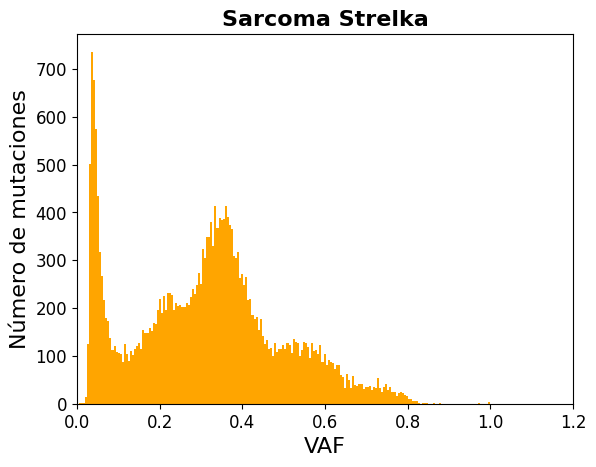

In [55]:
# Plot VAF in historgram
plt.hist(strelka_all_df['VAF'].tolist(), bins = 200, color = 'orange')
plt.xlim([0,1.2]) 
plt.ylabel('Número de mutaciones', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Strelka', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_strelka_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(strelka_all_df['VAF'].tolist())

In [56]:
# saving as tsv compressed file in directory project
# strelka_all_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_Strelka_VAF_all.tsv.gz', sep ='\t', index=None, compression = "gzip")

# 4/ Represent VAF considering SNPs and INDEL mutations

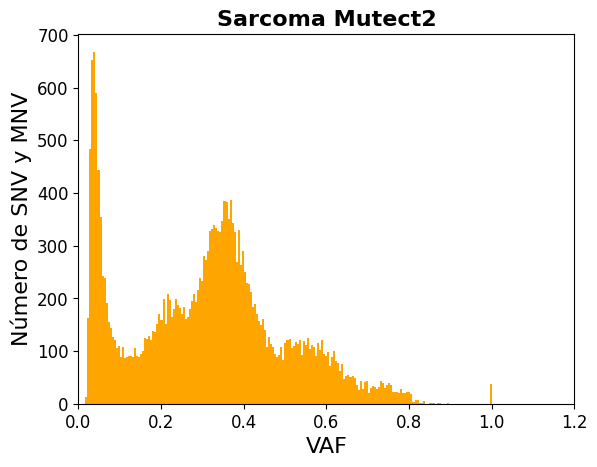

In [57]:
# Represent VAF of each indel for Mutect and Strelka SNV/INDEL tables obtained above

# For SNV in Mutect2
plt.hist(vaf_mutect_snv_df['VAF'].tolist(), bins = 200, color = "orange")
plt.xlim([0,1.2])
plt.ylabel('Número de SNV y MNV', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Mutect2', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_SNV_mutect_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_mutect_snv_df['VAF'].tolist())

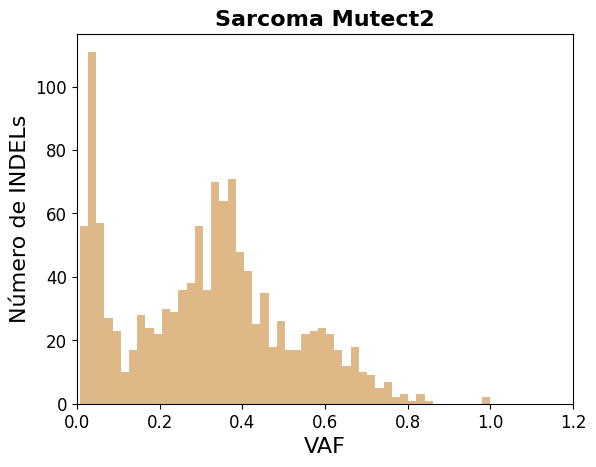

In [58]:
# For INDELs in Mutect2

plt.hist(vaf_mutect_indels_df['VAF'].tolist(), bins = 50, color = "burlywood")
plt.xlim([0,1.2])
plt.ylabel('Número de INDELs', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Mutect2', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_INDEL_mutect_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_mutect_indels_df['VAF'].tolist())

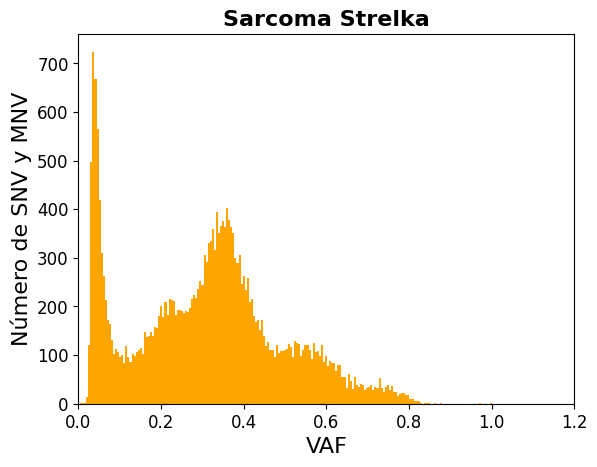

In [59]:
# For SNV in Strelka (the caller does not distinguish between MNV an SNV)

plt.hist(vaf_strelka_snv_df['VAF'].tolist(), bins = 200, color = "orange")
plt.xlim([0,1.2]) 
plt.ylabel('Número de SNV y MNV', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Strelka', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_SNV_strelka_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_strelka_snv_df['VAF'].tolist()) 

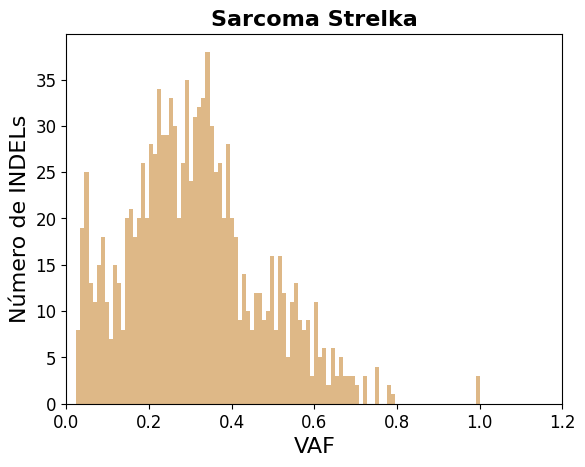

In [60]:
# For INDELs in Strelka

plt.hist(vaf_strelka_ind_df['VAF'].tolist(), bins = 100 ,color = "burlywood")
plt.ylabel('Número de INDELs', fontsize=16)
plt.xlim([0,1.2]) 
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Strelka', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_INDEL_strelka_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_strelka_ind_df['VAF'].tolist())